In [460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostClassifier, RandomForestClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif, chi2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn import svm
%matplotlib inline

In [596]:
# stock = pd.read_excel('./data/assets.xlsx', sheet_name='equity')
# bond = pd.read_excel('./data/assets.xlsx', sheet_name='bond')
# oil = pd.read_excel('./data/assets.xlsx', sheet_name='oil')
gold = pd.read_excel('./data/assets.xlsx', sheet_name='gold')

In [597]:
asset_name = 'Gold'

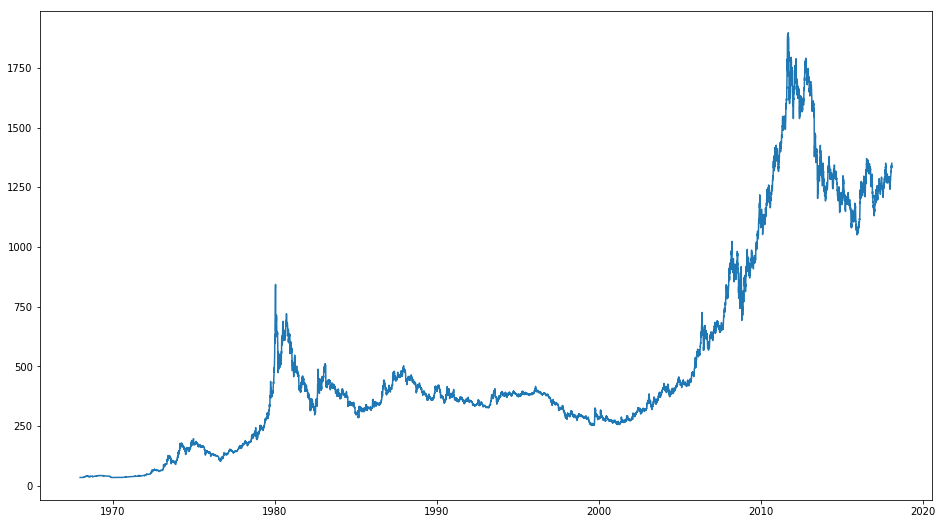

In [598]:
plt.figure(figsize=(16, 9))
plt.plot(gold[asset_name])

In [599]:
# fname = u'./data/三大产业对GDP增长的贡献率和拉动(季).xlsx'
# fname = u'./data/国内生产总值(季).xlsx'
# fname = u'./data/规模以上工业增加值当月(月).xlsx'
# fname = u'./data/固定资产投资完成额分行业同比(月).xlsx'
# fname = u'./data/货币供应量(月).xlsx'
# fname = u'./data/股票市场总体指标(月).xlsx'
# fname = u'./data/规模以上工业增加值累计(月).xlsx'
# fname = u'./data/macro.csv'
fname = u'./data/month_data.xlsx'
mdf = pd.read_excel(fname, index_col=0)
mdf = mdf.fillna(method='ffill').dropna()
fname = u'./data/quarter_data.xlsx'
qdf = pd.read_excel(fname, index_col=0)

In [600]:
# df = pd.read_excel(fname, index_col=0)

In [601]:
# df = qdf.copy()
# df = df.fillna(method='ffill').dropna(axis=1)
# df = mdf.join(qdf).fillna(method='ffill').dropna()
df = mdf.join(qdf).dropna()

In [602]:
df.head()

,工业增加值:累计同比,工业增加值:国有及国有控股企业:累计同比,工业增加值:集体企业:累计同比,工业增加值:股份制企业:累计同比,工业增加值:外商及港澳台投资企业:累计同比,工业增加值:股份合作企业:累计同比,M0:同比,M1:同比,M2:同比,金融机构:各项贷款余额:同比,...,GDP累计同比贡献率:第三产业,GDP累计同比贡献率:农林牧渔业,GDP累计同比贡献率:工业,GDP累计同比贡献率:建筑业,GDP累计同比贡献率:交通运输、仓储和邮政业,GDP累计同比贡献率:批发和零售业,GDP累计同比贡献率:住宿和餐饮业,GDP累计同比贡献率:金融业,GDP累计同比贡献率:房地产业,GDP累计同比贡献率:其他服务业
2002-03-31,10.9,8.7,8.3,12.7,10.5,10.7,8.20,10.10,14.40,11.9,...,53.7,2.5,40.10,3.6,5.4,9.4,3.7,4.4,4.2,26.8
2002-06-30,11.7,10.0,8.3,13.0,12.2,10.8,8.30,12.80,14.70,12.2,...,49.6,2.4,43.30,4.8,4.1,8.8,3.3,4.0,4.0,25.2
2002-09-30,12.2,10.8,8.8,13.5,12.8,10.8,7.80,15.90,16.50,14.2,...,47.5,4.0,43.40,5.2,4.3,8.0,3.1,3.7,4.3,24.0
2002-12-31,12.6,11.7,8.6,14.4,13.3,10.5,10.13,16.82,16.78,15.8,...,46.5,4.2,44.45,5.2,4.8,7.9,2.9,3.9,4.6,23.0
2003-03-31,17.2,16.4,11.9,18.8,20.0,11.9,10.05,20.12,18.54,19.9,...,46.4,2.1,47.10,4.6,4.6,7.4,2.8,5.6,4.7,21.2


In [603]:
# X = df.copy()
X = df.pct_change(periods=4) # 季度/月度同比序列
X = X.replace([-np.inf, np.inf], np.nan).fillna(method='ffill').dropna()

In [604]:
X.head()

,工业增加值:累计同比,工业增加值:国有及国有控股企业:累计同比,工业增加值:集体企业:累计同比,工业增加值:股份制企业:累计同比,工业增加值:外商及港澳台投资企业:累计同比,工业增加值:股份合作企业:累计同比,M0:同比,M1:同比,M2:同比,金融机构:各项贷款余额:同比,...,GDP累计同比贡献率:第三产业,GDP累计同比贡献率:农林牧渔业,GDP累计同比贡献率:工业,GDP累计同比贡献率:建筑业,GDP累计同比贡献率:交通运输、仓储和邮政业,GDP累计同比贡献率:批发和零售业,GDP累计同比贡献率:住宿和餐饮业,GDP累计同比贡献率:金融业,GDP累计同比贡献率:房地产业,GDP累计同比贡献率:其他服务业
2003-03-31,0.577982,0.885057,0.433735,0.480315,0.904762,0.112150,0.225610,0.992079,0.287500,0.672269,...,-0.135940,-0.160000,0.174564,0.277778,-0.148148,-0.212766,-0.243243,0.272727,0.119048,-0.208955
2003-06-30,0.384615,0.440000,0.349398,0.376923,0.557377,0.175926,0.484337,0.581250,0.417007,0.893443,...,-0.116935,-0.125000,0.108545,0.291667,-0.219512,-0.022727,-0.272727,0.175000,0.250000,-0.218254
2003-09-30,0.352459,0.324074,0.329545,0.325926,0.531250,0.175926,0.637179,0.164151,0.252727,0.654930,...,-0.143158,-0.200000,0.133641,0.384615,-0.186047,0.150000,-0.096774,0.108108,0.023256,-0.316667
2003-12-31,0.349206,0.222222,0.337209,0.270833,0.503759,0.323810,0.411649,0.111772,0.168057,0.335443,...,-0.161290,-0.214286,0.167829,0.250000,-0.208333,0.025316,-0.034483,-0.128205,-0.065217,-0.234783
2004-03-31,0.029070,-0.115854,-0.033613,-0.037234,0.055000,0.067227,0.273632,-0.000994,0.030205,0.010050,...,-0.019397,0.428571,0.033970,-0.369565,0.847826,-0.905405,-0.535714,-0.410714,-0.234043,0.320755


In [605]:
X.shape

(59, 56)

In [606]:
# ret_df = stock.resample('M').last().pct_change()
# ret_df = stock.resample('Q').last().pct_change()
ret_df = gold.resample('Q').last().pct_change()

In [607]:
X = X[X.index >= ret_df.index[0]]

In [608]:
ret_df = ret_df.loc[X.index]

# 股票数据验证——回归

In [609]:
y = ret_df[asset_name].copy()

In [610]:
coef = mutual_info_regression(X, y)

In [611]:
X.columns[coef != 0]

Index([u'工业增加值:累计同比', u'工业增加值:集体企业:累计同比', u'工业增加值:股份合作企业:累计同比', u'M0:同比',
       u'M1:同比', u'M2:同比', u'工业增加值:当月同比', u'CPI:食品:当月同比', u'CPI:非食品:当月同比',
       u'CPI:教育文化和娱乐:当月同比', u'CPI:医疗保健:当月同比', u'PPI:全部工业品:当月同比',
       u'PPI:生产资料:当月同比', u'PPI:生产资料:采掘工业:当月同比', u'PPI:生产资料:原材料工业:当月同比',
       u'PPI:生产资料:加工工业:当月同比', u'PPI:生活资料:食品类:当月同比', u'PPI:生活资料:一般日用品类:当月同比',
       u'PPI:生活资料:耐用消费品类:当月同比', u'GDP:现价:工业:当季值', u'GDP:现价:住宿和餐饮业:当季值',
       u'GDP累计同比贡献率:农林牧渔业', u'GDP累计同比贡献率:工业', u'GDP累计同比贡献率:交通运输、仓储和邮政业'],
      dtype='object')

## 滚动训练预测

In [612]:
# reg = ExtraTreesRegressor(max_depth=3)
# reg = RandomForestRegressor(max_depth=2, n_estimators=5)
# reg = xgb.XGBRegressor(max_depth=3, n_estimators=20)
# reg.fit(X_train, y_train)
# print reg.feature_importances_
# print reg.score(X_train, y_train)
# print reg.score(X_test, y_test)
pred = pd.Series(index=y.index)
K = 36
for i, date in enumerate(X.index):
    train, label = X[X.columns[coef != 0]][X.index < date].iloc[-K:], y[y.index < date][-K:]
    if train.shape[0] == K:
        reg = xgb.XGBRegressor(max_depth=2, n_estimators=20)
        reg.fit(train, label)
        
        val = reg.predict(X[X.columns[coef != 0]].iloc[i:i+1])[0]
        pred.loc[date] = val
        print date, reg.score(train, label), val, y[date]

2012-03-31 00:00:00 -0.753402870181 0.07968 0.0547792950143
2012-06-30 00:00:00 -0.779695744943 0.0812148 -0.0549450549451
2012-09-30 00:00:00 -0.63041048957 0.0857662 0.134756291813
2012-12-31 00:00:00 -0.624937155593 0.12655 -0.0656934306569
2013-03-31 00:00:00 -0.542407160459 0.107383 -0.0369591346154
2013-06-30 00:00:00 -0.550504679561 0.0790933 -0.249141965679
2013-09-30 00:00:00 -0.194764952831 0.0840119 0.110118429254
2013-12-31 00:00:00 -0.167435409705 0.084794 -0.100505334082
2014-03-31 00:00:00 -0.0958482663487 0.076974 0.076987099459
2014-06-30 00:00:00 -0.119066707831 0.131161 0.0146831530139
2014-09-30 00:00:00 -0.116028611217 0.0721982 -0.0784463061691
2014-12-31 00:00:00 -0.0673489108073 0.0770122 -0.00888429752066
2015-03-31 00:00:00 -0.0845838682244 0.0831048 -0.0166770898478
2015-06-30 00:00:00 -0.125610157918 0.0769475 -0.00360398558406
2015-09-30 00:00:00 -0.103576258916 0.0715205 -0.0446808510638
2015-12-31 00:00:00 -0.0826617684725 0.0724264 -0.0536748329621
2016-

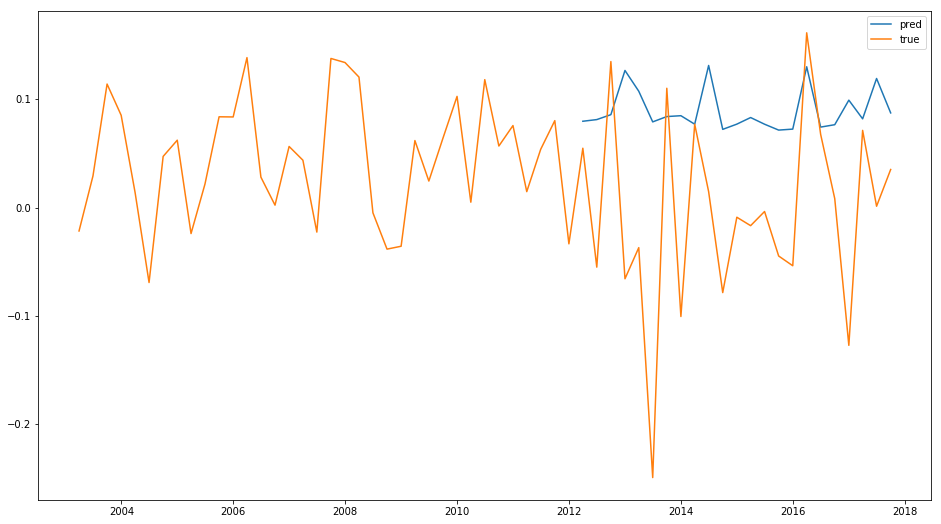

In [613]:
plt.figure(figsize=(16, 9))
plt.plot(pred, label='pred')
plt.plot(y, label='true')
plt.legend()

0.137147428145
0.221848318125


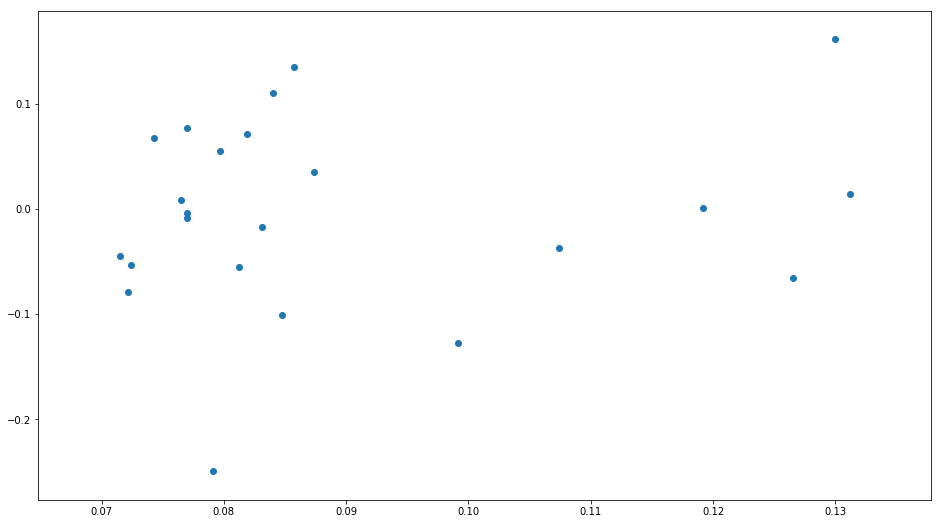

In [614]:
plt.figure(figsize=(16, 9))
plt.scatter(pred, y)
print y.corr(pred)
print y.corr(pred.pct_change())

# 股票数据验证（分类）

In [615]:
y = ret_df[asset_name].copy()
y[y >= 0] = 1
y[y < 0] = 0
# y[y >= 0.05] = 2
# y[(y >= -0.05) & (y < 0.05)] = 1
# y[y < -0.05] = 0

In [616]:
X.shape, y.shape

((59, 56), (59L,))

In [617]:
print y[y == 0].shape
print y[y == 1].shape
print y[y == 2].shape

(20L,)
(39L,)
(0L,)


In [618]:
# X_train.columns[clf.feature_importances_ != 0]
# clf.score(X_train, y_train)
clf = xgb.XGBClassifier(max_depth=2, n_estimators=50)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=10)
print clf.score(X, y)

1.0


In [619]:
clf.predict_proba(X).shape

(59L, 2L)

In [620]:
scores

array([ 0.66666667,  0.66666667,  0.83333333,  0.66666667,  0.16666667,
        1.        ,  0.83333333,  0.66666667,  0.83333333,  0.8       ])

In [621]:
scores.mean()

0.71333333333333326

In [622]:
pred = pd.Series(index=y.index)
K = 12
for i, date in enumerate(X.index):
    train, label = X[X.index < date].iloc[-K:], y[y.index < date][-K:]
    if train.shape[0] == K:
        reg = xgb.XGBClassifier(max_depth=2, n_estimators=20)
        scores = cross_val_score(clf, train, label, cv=5)
        reg.fit(train, label)
        
        val = reg.predict_proba(X.iloc[i:i+1])[0, 1]
#         val = reg.predict(X.iloc[i:i+1])[0]
        pred.loc[date] = val
        print date, reg.score(train, label), scores.mean(), val, ret_df[asset_name].loc[date]

2006-03-31 00:00:00 1.0 0.8 0.422448 0.138401559454
2006-06-30 00:00:00 1.0 0.866666666667 0.770112 0.0280821917808
2006-09-30 00:00:00 1.0 0.866666666667 0.770635 0.00224850099933
2006-12-31 00:00:00 1.0 0.866666666667 0.754373 0.0564187785625
2007-03-31 00:00:00 1.0 0.866666666667 0.83042 0.0437313198049
2007-06-30 00:00:00 1.0 0.866666666667 0.817933 -0.0226073850791
2007-09-30 00:00:00 1.0 0.866666666667 0.685608 0.137625289129
2007-12-31 00:00:00 1.0 0.866666666667 0.685297 0.13385293121
2008-03-31 00:00:00 1.0 0.866666666667 0.482148 0.120442319187


C:\Users\zhangyang01\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


2008-06-30 00:00:00 0.916666666667 0.95 0.820324 -0.00480128034142
2008-09-30 00:00:00 1.0 0.866666666667 0.525612 -0.0383275261324
2008-12-31 00:00:00 1.0 0.6 0.602817 -0.0356744704571
2009-03-31 00:00:00 1.0 0.5 0.290409 0.0618497109827
2009-06-30 00:00:00 0.916666666667 0.5 0.655578 0.0244964616222
2009-09-30 00:00:00 1.0 0.5 0.448301 0.0640276301807
2009-12-31 00:00:00 1.0 0.7 0.71607 0.102621722846
2010-03-31 00:00:00 1.0 0.7 0.567686 0.00498188405797
2010-06-30 00:00:00 1.0 0.7 0.685744 0.118071203245
2010-09-30 00:00:00 1.0 0.8 0.721288 0.0568319226119
2010-12-31 00:00:00 1.0 0.8 0.721288 0.0757055682685
2011-03-31 00:00:00 1.0 0.8 0.49811 0.0147137032441
2011-06-30 00:00:00 1.0 0.6 0.724747 0.0538085255066
2011-09-30 00:00:00 1.0 0.866666666667 0.749618 0.0802387267905
2011-12-31 00:00:00 0.916666666667 0.95 0.820223 -0.0334561080417
2012-03-31 00:00:00 0.916666666667 0.95 0.810934 0.0547792950143
2012-06-30 00:00:00 0.916666666667 0.95 0.810948 -0.0549450549451
2012-09-30 00:0

In [623]:
pred = pred.dropna()
y_true = y[y.index >= pred.index[0]]

In [624]:
# print accuracy_score(pred, y_true)
# print roc_auc_score(pred, y_true)
# print confusion_matrix(pred, y_true)

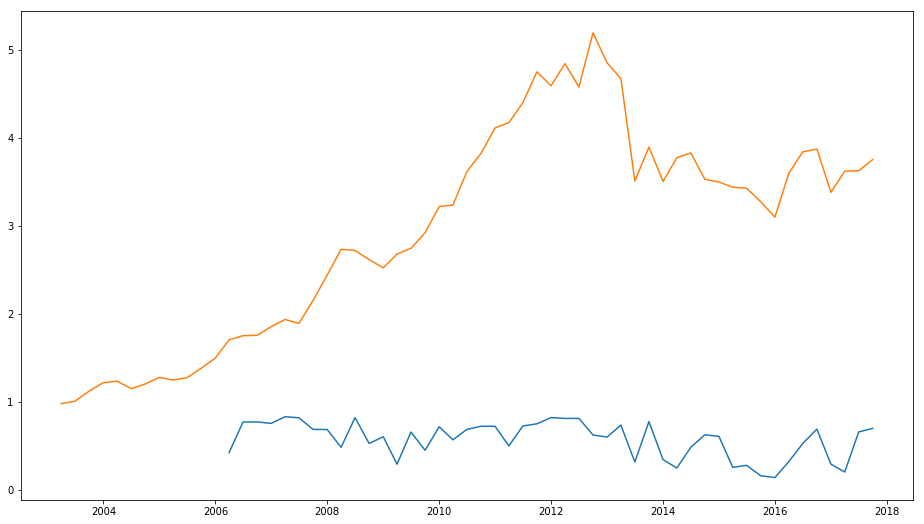

In [625]:
plt.figure(figsize=(16, 9))
plt.plot(pred, label='pred')
plt.plot((1+ret_df[asset_name]).cumprod(), label='true')

0.20413292280882928

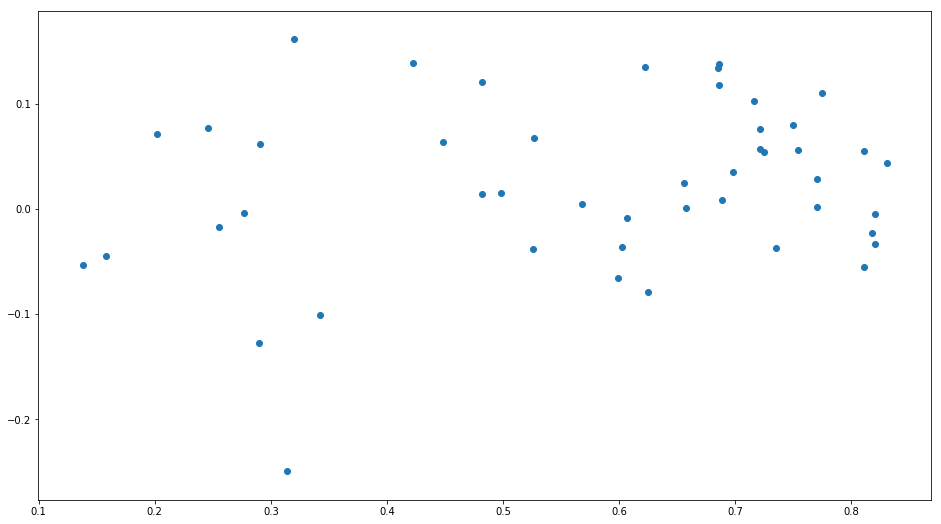

In [626]:
plt.figure(figsize=(16, 9))
plt.scatter(pred, ret_df[asset_name][ret_df.index >= pred.index[0]])
pred.corr(ret_df[asset_name])

In [627]:
pred.to_excel('./data/gold_pred.xlsx')